# Hypergraph datasets

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
from tqdm import tqdm

import xgi
from utils import (
    compute_eigenvalues,
    compute_eigenvalues_multi,
    shuffle_hyperedges,
)

sb.set_theme(style="ticks", context="paper")

fig_dir = "figures/"
results_dir = "results/"

Path(fig_dir).mkdir(parents=True, exist_ok=True)
Path(results_dir).mkdir(parents=True, exist_ok=True)

In [2]:
data_names = [
    "hospital-lyon",
    "contact-primary-school",
]

HGs_data = {}
for name in tqdm(data_names):
    HGs_data[name] = xgi.load_xgi_data(name, max_order=2)
    # HGs[name] = xgi.read_json(f"data/xgi-data/{name}.json")

100%|███████████████████████████████████████████████████████████| 2/2 [02:34<00:00, 77.14s/it]


## Single dataset

In [13]:
i = 0
name = data_names[i]
net_name = data_names[i]
print(name)
H0 = HGs_data[name]
print("max order:", xgi.max_edge_order(H0))
print(H0)
print(xgi.is_connected(H0))
H0 = xgi.largest_connected_hypergraph(H0)
print(H0)
print(xgi.is_connected(H0))
H0.cleanup()
print(H0)

hospital-lyon
max order: 2
Hypergraph named hospital-Lyon with 75 nodes and 19743 hyperedges
True
Hypergraph named hospital-Lyon with 75 nodes and 19743 hyperedges
True
Hypergraph named hospital-Lyon with 75 nodes and 2066 hyperedges


In [14]:
ps = [0, 0.2, 0.4, 0.6, 0.8, 1]
n_rep = 50

n_p = len(ps)

HGs = []

for p in tqdm(ps):

    HGs_p = []
    for i in range(n_rep):

        HG = shuffle_hyperedges(H0, order=2, p=p)
        # HG.cleanup()

        HGs_p.append(HG)
    HGs.append(HGs_p)

100%|███████████████████████████████████████████████████████████| 6/6 [00:16<00:00,  2.75s/it]


In [15]:
alphas = np.arange(0, 1.01, 0.1)
n_alpha = len(alphas)
N = H0.num_nodes

lyaps_HG = np.zeros((n_p, n_rep, len(alphas), N))

for j, p in enumerate(tqdm(ps)):
    for ii in range(n_rep):

        name = f"{p}_{ii}"
        HG = HGs[j][ii]

        for i, alpha in enumerate(alphas):
            lyap_multi = compute_eigenvalues_multi(
                HG, orders=[1, 2], weights=[1 - alpha, alpha]
            )

            lyap_multi = np.sort(lyap_multi)[::-1]
            lyaps_HG[j, ii, i, :] = lyap_multi

100%|███████████████████████████████████████████████████████████| 6/6 [01:10<00:00, 11.76s/it]


In [16]:
np.savez(
    f"{results_dir}{net_name}_shuffle",
    lyaps_HG=lyaps_HG,
    alphas=alphas,
)

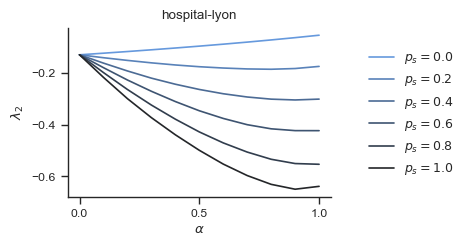

In [17]:
fig, ax = plt.subplots(figsize=(3.4, 2.2))

palette = sb.dark_palette("#69d", reverse=True)
sb.set_palette(palette)

for i in range(n_p)[:]:
    ax.plot(
        alphas, np.mean(lyaps_HG[i, :, :, 1], axis=0), "-", label=f"$p_s={ps[i]:.1f}$"
    )

ax.set_ylabel(r"$\lambda_2$")
ax.set_xlabel(r"$\alpha$")


# ax.set_yticks([-0.0, -0.5, -1])
ax.set_xticks([0, 0.5, 1])

ax.legend(
    loc="lower left",
    frameon=False,
    prop={"size": 9},
    ncol=1,
    bbox_to_anchor=(1.1, 0.05),
)
ax.set_title(net_name)

# plt.grid()
sb.despine()

fig_name = f"lambda-shuffle_{net_name}"

plt.savefig(f"{fig_dir}{fig_name}.png", dpi=250, bbox_inches="tight")
plt.savefig(f"{fig_dir}{fig_name}.pdf", dpi=250, bbox_inches="tight")

## Both datasets

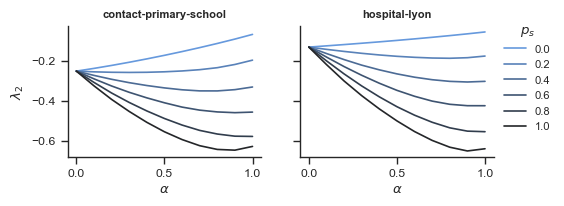

In [25]:
palette = sb.dark_palette("#69d", reverse=True, n_colors=len(ps))
sb.set_palette(palette)

fig, axs = plt.subplots(1, 2, figsize=(5.5, 1.7), sharex=True, sharey=True)

for kk, net_name in enumerate(data_names):

    try:

        ax = axs[kk - 1]
        data = np.load(f"{results_dir}{net_name}_shuffle.npz")

        lyaps_HG = data["lyaps_HG"]
        alphas = data["alphas"]

        for i in range(n_p)[:]:
            ax.plot(
                alphas,
                np.mean(lyaps_HG[i, :, :, 1], axis=0),
                "-",
                label=f"{ps[i]:.1f}",
            )

        ax.set_title(f"{net_name}", weight="bold", fontsize="small")

    except:
        print(net_name, "not yet computed")
        pass

axs[0].set_ylabel(r"$\lambda_2$")

axs[0].set_xlabel(r"$\alpha$")
axs[1].set_xlabel(r"$\alpha$")
# axs[2].set_xlabel(r"$\alpha$")
axs[-1].set_xticks([0, 0.5, 1])

axs[-1].legend(
    title="$p_s$",
    loc="center left",
    bbox_to_anchor=(1, 0.6),
    frameon=False,
    fontsize="small",
)

sb.despine()

fig_name = f"figure_S8_lambda-shuffle_all_real_hypergraphs"

plt.savefig(f"{fig_dir}{fig_name}.png", dpi=250, bbox_inches="tight")
plt.savefig(f"{fig_dir}{fig_name}.pdf", dpi=250, bbox_inches="tight")